# Ernest Young Data Science Challenge 2023 - Level 1 

### 1) Imports and Setting Subscription Key

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

In [3]:
# Data Science
import numpy as np
import pandas as pd

In [4]:
# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle

In [5]:
# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix

In [6]:
# Planetary Computer Tools
import pystac
import pystac_client
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc

In [7]:
pc.settings.set_subscription_key("9653e89dc656440c8f7f2bf726841f3a")

In [8]:
!pip install keras
!pip install tensorflow

  Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.0 MB/s eta 0:00:0000:0100:01
  Using cached tensorflow_io_gcs_filesystem-0.31.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.4 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 30.8 MB/s eta 0:00:00
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached libclang-15.0.6.1-py2.py3-none-manylinux2010_x86_64.whl (21.5 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 79.6 MB/s eta 0:00:00:00:0100:01
  Using cached flatbuffers-23.3.3-py2.py3-none-any.whl (26 kB)
  Using cached termcolor-2.2.0-py3-none-any.whl (6.6 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 20.8 MB/s eta 0:00:00
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.

In [48]:
# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
tqdm.pandas()
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

### 2) Setting the Global Variables and Utility Functions

In [11]:
date_interval = '2020-11-01/2021-12-31'
bbox = 0.0004 # Surrounding box in degrees, yields approximately 5x5 pixel region
date_range = date_interval.split("/")
dates = pd.date_range(date_range[0], date_range[1], periods=50)
lt = 30

In [12]:
def combine_two_datasets(dataset1,dataset2):
    
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

### 3) Loading in the Raw Satellite Data

#### 3.1) Response Variable

In [13]:
crop_presence_data = pd.read_csv("Crop_Location_Data_20221201.csv")
crop_latlong = crop_presence_data['Latitude and Longitude']
crop_presence_data.head(3)

,Latitude and Longitude,Class of Land
0,"(10.323727047081501, 105.2516346045924)",Rice
1,"(10.322364360592521, 105.27843410554115)",Rice
2,"(10.321455902933202, 105.25254306225168)",Rice


In [14]:
#Reading the coordinates for the submission

test_file = pd.read_csv('challenge_1_submission_template_correct_columns_fixed.csv')
test_file.head(3)

,id,target
0,"(10.18019073690894, 105.32022315786804)",NaN
1,"(10.561107033461816, 105.12772097986661)",NaN
2,"(10.623790611954897, 105.13771401411867)",NaN


#### 3.2) Predictor Variables

##### 3.2.1) Sentinel-1-rtc

Loading in the Sentinel-1-rtc Satellite images:
- Using the [VV, VH] assets
- Also returning the time for each [VV, VH] pair to be used at a later time for time series interpolation
- Use of bbox parameter is to get a 5x5 box from each extracted satellite image at a certain longitude and latitude position

In [ ]:
def get_sentinel1_data(latlong, time_of_interest, bbox):
    
    resolution = 10  # meters per pixel 
    scale = resolution / 111320.0 # degrees per pixel for crs=4326 

    lat_long=latlong.replace('(','').replace(')','').replace(' ','').split(',')
    
    min_lon = float(lat_long[1])-bbox/2
    min_lat = float(lat_long[0])-bbox/2
    max_lon = float(lat_long[1])+bbox/2
    max_lat = float(lat_long[0])+bbox/2

    bbox_of_interest = (min_lon, min_lat, max_lon, max_lat)

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
    )
    search = catalog.search(
        collections=["sentinel-1-rtc"], 
        bbox=bbox_of_interest, 
        datetime=time_of_interest
    )
    items = list(search.get_all_items())
    
    data = stac_load(items, bands=["vv", "vh"], patch_url=pc.sign, bbox=bbox_of_interest, crs="EPSG:4326", resolution=scale)
    mean = data.mean(dim=['latitude','longitude']).compute()
    
    return mean.vv, mean.vh, mean.time

Calling the get_sentinel1_data() function:
- Iterative function that calls this function for each coordinate in the Crop_Location_Data.csv file
- Appends each row of data

In [ ]:
def extract_sentinel1(long_lats, date_interval, bbox):
    data = pd.DataFrame(columns = ['VV','VH','Dates'])

    for coordinates in tqdm(long_lats):
        vv, vh, dates = get_sentinel1_data(coordinates, date_interval, bbox)
        data = data.append({'VV':np.array(vv), 'VH':np.array(vh), 'Dates':np.array(dates)}, ignore_index=True)
        
    return data

##### 3.2.2) Sentinel-2 Level2a

Loading in the Sentinel-2 Level 2a Satellite images:
- Using the B04 (Red) and B08 (NIR) bands, and SCL (for cloud filtering) from the dataset
- Using these to calculate NDVI in the future
- Not using bbox here but note the change of resolution (20) as the images have different resolution in sentinel-2 to sentinel-1
- Not calculating the mean just yet so we can do some cloud filtering later

In [ ]:
def get_sentinel2_data(lat_long, time_of_interest, bbox=0, lt=30):
    
    resolution = 20  # meters per pixel 
    scale = resolution / 111320.0 # degrees per pixel for CRS:4326 

    lat_long=lat_long.replace('(','').replace(')','').replace(' ','').split(',')
    
    min_lon = float(lat_long[1])-bbox/2
    min_lat = float(lat_long[0])-bbox/2
    max_lon = float(lat_long[1])+bbox/2
    max_lat = float(lat_long[0])+bbox/2

    bbox_of_interest = (min_lon, min_lat, max_lon, max_lat)
    
    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=pc.sign_inplace,
    )
    
    search = catalog.search(
        collections=["sentinel-2-l2a"],
        bbox=bbox_of_interest,
        datetime=time_of_interest,
        query={"eo:cloud_cover": {"lt": lt}},
    )
    items = list(search.get_all_items())
    
    data = stac_load(items, bands=["red", "green", "blue", "nir", "SCL"], patch_url=pc.sign, bbox=bbox_of_interest, crs="EPSG:4326", resolution=scale)
    
    return data.red, data.green, data.blue, data.nir, data.SCL, data.time

In [ ]:
def extract_sentinel2(long_lats, date_interval, bbox, lt):
    data = pd.DataFrame(columns = ['Red', 'NIR', 'SCL', 'Dates'])

    for coordinates in tqdm(long_lats):
        red, green, blue, nir, scl, dates = get_sentinel2_data(coordinates, date_interval, bbox, lt)
        sentinel2_data = sentinel2_data.append({'Red':np.array(red), 'NIR':np.array(nir), 'SCL':np.array(scl), 'Dates':np.array(dates)}, ignore_index=True)

Running the data loading functions and saving the values to file:
- Takes 4-5 hours to extract sentinel-1 values
- Takes 1-2 hours to extract sentinel-2 values

In [ ]:
sentinel1_data = extract_sentinel1(crop_latlong, date_interval, bbox)
sentinel1_test = extract_sentinel1(test_file['id'], date_interval, bbox)

In [ ]:
sentinel2_data = extract_sentinel2(crop_latlong, date_interval, bbox, lt)
sentinel2_test = extract_sentinel2(test_file['id'], date_interval, bbox, lt)

In [ ]:
sentinel1_data.to_pickle('sentinel1_data.df')
sentinel2_data.to_pickle('sentinel2_data.df')

In [ ]:
sentinel1_test.to_pickle('sentinel1_test.df')
sentinel2_test.to_pickle('sentinel2_test.df')

### 4) Loading the Downloaded Data from file and Pre-processing

The following pre-processing steps will include generating time-series data for VV, VH, Red, NIR and SCL.

It is clear to see from the data that each data point extracted from the satellites is not recorded on the exact day. Therefore, it was decided that I would generate a fixed time series list that would have interoplated values for VV, VH and NDVI.

It would not be a good idea to interpolate Red, NIR and SCL values, therefore NDVI was calculated first before any interpolation.

Lastly, the first value of each interpolated feature is NaN, so this was removed and for any other NaN values that now exist at the beginning of each time series feature list, it was calculated by essentially copying from the nearest value in the list.

##### NDVI = (NIR-Red) / (NIR+Red)

SCL values are used to filter clouds from Sentinel-2 data. Each SCL value is an integer from 0-11

- 0  - NODATA - MAGENTA
- 1  - Saturated or Defective - RED
- 2  - Dark Areas - BLACK
- 3  - Cloud Shadow - DARK GREY
- 4  - Vegetation - GREEN
- 5  - Bare Ground - BROWN
- 6  - Water - BLUE
- 7  - Unclassified - MAROON
- 8  - Cloud - LIGHT GREY
- 9  - Definitely Cloud - WHITE
- 10 - Thin Cloud - LIGHT BLUE
- 11 - Snow or Ice - PINK

In [15]:
def generate_sentinel1_timeseries(dates, data):
    vvs_vhs = pd.DataFrame(columns = ["VV", "VH"])

    dummy_frame_vv = pd.DataFrame(np.NaN, index=dates, columns=["VV"])
    dummy_frame_vh = pd.DataFrame(np.NaN, index=dates, columns=["VH"])

    for i in range(data.shape[0]):
        tmp_vv = pd.DataFrame(data["VV"][i], index=data["Dates"][i], columns=["VV"])
        tmp_vh = pd.DataFrame(data["VH"][i], index=data["Dates"][i], columns=["VH"])

        vv = tmp_vv.combine_first(dummy_frame_vv).interpolate('time').loc[dummy_frame_vv.index][1:]
        vh = tmp_vh.combine_first(dummy_frame_vh).interpolate('time').loc[dummy_frame_vh.index][1:]

        vvs_vhs = vvs_vhs.append({"VV":np.array(vv["VV"]), "VH":np.array(vh["VH"])}, ignore_index=True)
        
    return vvs_vhs

In [16]:
def calculate_ndvi(data):
    reds = []
    nirs = []
    ndvi_ts = []

    for i in range(data.shape[0]):
        cloud_mask = \
            (data["SCL"][i] != 0) & \
            (data["SCL"][i] != 1) & \
            (data["SCL"][i] != 3) & \
            (data["SCL"][i] != 8) & \
            (data["SCL"][i] != 9) & \
            (data["SCL"][i] != 10) & \
            (data["SCL"][i] != 11) 

        red = data["Red"][i] * cloud_mask
        nir = data["NIR"][i]

        red[red == 0] = np.nan
        red_mean = np.nanmean(np.nanmean(red, axis=1), axis=1)

        nir_mean = nir.mean(axis=1)
        nir_mean = nir_mean.mean(axis=1)

        ndvi = (nir_mean - red_mean) / (nir_mean + red_mean)

        reds.append(red_mean)
        nirs.append(nir_mean)
        ndvi_ts.append(ndvi)
        
    return ndvi_ts

In [17]:
def generate_ndvi_timeseries(data, dates):
    ndvi_ts = calculate_ndvi(data)
    
    ndvi_ts_int = pd.DataFrame(columns = ["NDVI"])

    dummy_frame_ndvi = pd.DataFrame(np.NaN, index=dates, columns=["NDVI"])

    for i in range(data.shape[0]):
        tmp_ndvi = pd.DataFrame(ndvi_ts[i], index=data["Dates"][i], columns=["NDVI"])

        ndvi = tmp_ndvi.combine_first(dummy_frame_ndvi).interpolate('time').ffill().bfill().loc[dummy_frame_ndvi.index][1:]

        ndvi_ts_int = ndvi_ts_int.append({"NDVI":np.array(ndvi["NDVI"])}, ignore_index=True)
        
    return ndvi_ts_int

The features appear as individual lists, to prepare the data for a multi-variate time series binary classification model, I need to make sure that the time series data are stacked together.

In [18]:
def stack_lists(crop_data):
    data = []

    for i in range(crop_data.shape[0]):
        ts = np.array([crop_data["VV"][i], crop_data["VH"][i], crop_data["NDVI"][i]])
        stack = np.dstack((ts[0],ts[1],ts[2]))[0]
        data.append(stack)
    
    data = np.array(data)
    
    return data

Prepocessing function that collects all of the data processing functions together:

In [19]:
def preprocess(sentinel1_df, sentinel2_df, lat_long_col, crop_presence_data):
    sentinel1_data = pd.read_pickle(sentinel1_df)
    sentinel2_data = pd.read_pickle(sentinel2_df)
    
    vvs_vhs = generate_sentinel1_timeseries(dates, sentinel1_data)
    ndvi_ts_int = generate_ndvi_timeseries(sentinel2_data, dates)
    
    crop_data = combine_two_datasets(crop_presence_data,vvs_vhs)
    crop_data = combine_two_datasets(crop_data,ndvi_ts_int)
    
    data = stack_lists(crop_data)
    
    return data

Preprocessing the training data and the test data, and encoding the labels to 0 and 1.

In [20]:
data = preprocess('sentinel1_data.df', 'sentinel2_data.df', 'Class of Land', crop_presence_data)
X_test = preprocess('sentinel1_test.df', 'sentinel2_test.df', 'id', test_file)

In [21]:
le = preprocessing.LabelEncoder()
labels = le.fit_transform(crop_presence_data["Class of Land"])

Shuffling the training data

In [22]:
X_train, y_train = shuffle(data, labels, random_state=40)

Standardising the training values and using the trained transformers on the test data.

In [23]:
def standardise(train, test):
    sc = StandardScaler()
    norm_train = sc.fit_transform(train)
    norm_test = sc.transform(test)
    
    return norm_train, norm_test

Formatting the standardised data correctly. There is a reason the standardisation for each feature was isolated

In [24]:
def scale_dataset(train, test):
    train_vv, test_vv = standardise(train[:,:,0], test[:,:,0])
    train_vh, test_vh = standardise(train[:,:,1], test[:,:,1])
    train_ndvi, test_ndvi = standardise(train[:,:,2], test[:,:,2])
    
    train = np.stack((train_vv, train_vh, train_ndvi), axis=2)
    test = np.stack((test_vv, test_vh, test_ndvi), axis=2)
    
    return train, test

In [25]:
X_train_norm, X_test_norm = scale_dataset(X_train, X_test)

### 5) Preparing the Model

Using Keras to create a LSTM model that expects multi-variate time series data for binary classification

In [104]:
def build_model(lstm_units, num_hidden, opt):
    
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(49,3)))
    model.add(LSTM(units=num_hidden, return_sequences=False, input_shape=(49,3)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

### 6) Training a Model and Evaluating it

In [45]:
def train_model(model, epochs = 20, batch = 2, val_split=0.1):
    history = model.fit(X_train_norm, y_train, epochs=epochs, batch_size=batch, validation_split = val_split)
    
    return history

In [49]:
adam = optimizers.Adam(
            learning_rate = 0.001,
            beta_1 = 0.9)
        
model = build_model(100, 50, adam) 

2023-03-23 17:45:24.900014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-23 17:45:24.902274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-23 17:45:24.904008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [50]:
history = train_model(model, epochs = 10, batch = 32)

Epoch 1/10


2023-03-23 17:45:26.369119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-23 17:45:26.371307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-23 17:45:26.373017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

17/17 [==============================] - ETA: 0s - loss: 0.5519 - accuracy: 0.8093

2023-03-23 17:45:28.771214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-23 17:45:28.773507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-23 17:45:28.775133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

17/17 [==============================] - 3s 65ms/step - loss: 0.5519 - accuracy: 0.8093 - val_loss: 0.3487 - val_accuracy: 0.9167
Epoch 2/10
17/17 [==============================] - 1s 36ms/step - loss: 0.2785 - accuracy: 0.9426 - val_loss: 0.0127 - val_accuracy: 1.0000
Epoch 3/10
17/17 [==============================] - 1s 35ms/step - loss: 0.1605 - accuracy: 0.9685 - val_loss: 0.0303 - val_accuracy: 1.0000
Epoch 4/10
17/17 [==============================] - 1s 35ms/step - loss: 0.0492 - accuracy: 0.9944 - val_loss: 0.0197 - val_accuracy: 1.0000
Epoch 5/10
17/17 [==============================] - 1s 35ms/step - loss: 0.0374 - accuracy: 0.9944 - val_loss: 0.0730 - val_accuracy: 0.9833
Epoch 6/10
17/17 [==============================] - 1s 34ms/step - loss: 0.0262 - accuracy: 0.9963 - val_loss: 0.0741 - val_accuracy: 0.9833
Epoch 7/10
17/17 [==============================] - 1s 37ms/step - loss: 0.0243 - accuracy: 0.9963 - val_loss: 0.0783 - val_accuracy: 0.9833
Epoch 8/10
17/17 [======

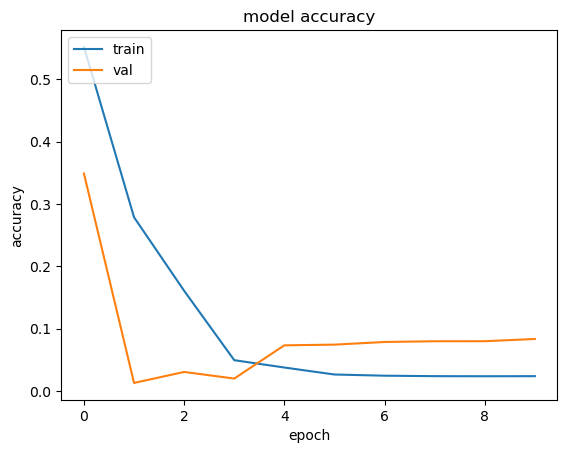

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### 7) Hyper-parameter Tuning the model

In [ ]:
lr_s = [1e-03, 1e-04, 1e-05, 1e-06]

beta_s = [0.9, 0.93, 0.96, 0.99]
mtm_s = [0.0, 0.3, 0.6, 0.9]

In [ ]:
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(21,42), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.2)

for i in range(len(lr_s)):
    for j in range(len(beta_s)):
        adam = optimizers.Adam(
                learning_rate = lr_s[i],
                beta_1 = beta_s[j])
                   
        model = build_model(100, 50, adam) 
        history = train_model(model, epochs=50, batch=2)
        
        axes[j][i].plot(history.history['accuracy'])
        axes[j][i].plot(history.history['val_accuracy'])
        
        title = 'Accuracy' + ' lr = ' + str(lr_s[i]) + ', beta = ' + str(beta_s[j])
        axes[j][i].set_title(title)
        axes[j][i].set_ylabel('accuracy')
        axes[j][i].set_xlabel('epoch')
        axes[j][i].legend(['train', 'val'], loc='upper left')
        
        axes[j+4][i].plot(history.history['loss'])
        axes[j+4][i].plot(history.history['val_loss'])
        
        title = 'Loss' + ' lr = ' + str(lr_s[i]) + ', beta = ' + str(beta_s[j])
        axes[j+4][i].set_title(title)
        axes[j+4][i].set_ylabel('loss')
        axes[j+4][i].set_xlabel('epoch')
        axes[j+4][i].legend(['train', 'val'], loc='upper left')
        
plt.show()

Grid search performed for ADAM optimizer and below shows the accuracy and loss plots for different learning rates and beta_1 decay rates.

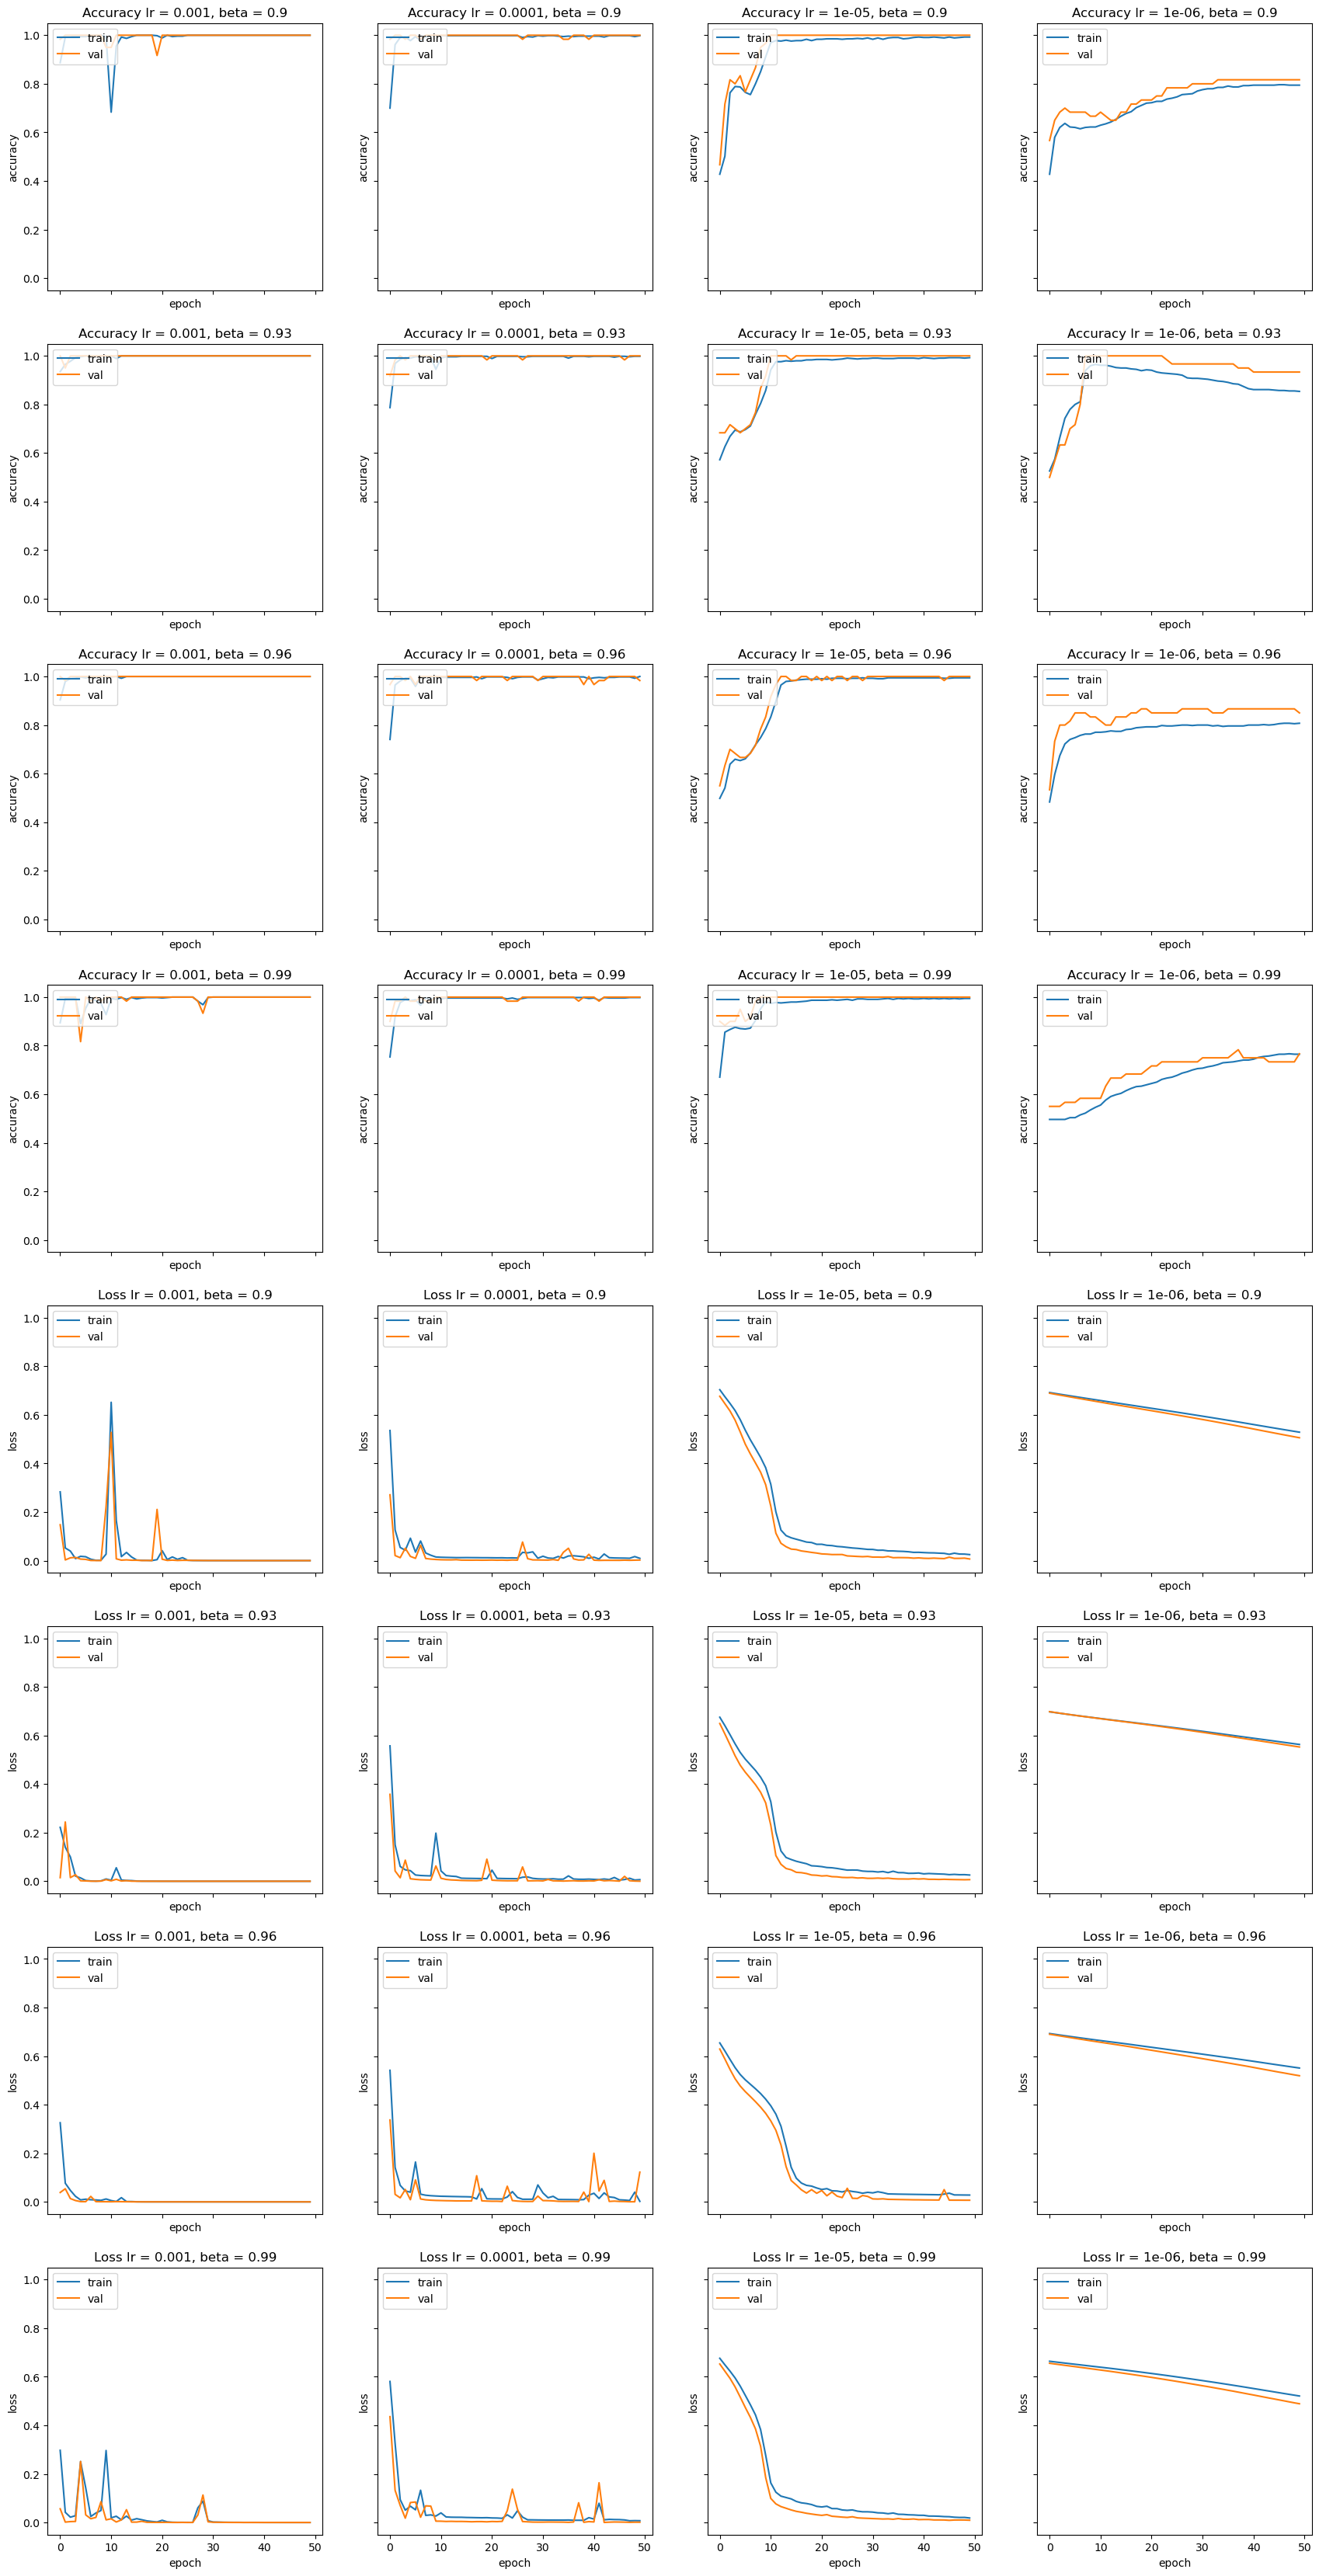

In [ ]:
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(21,42), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.2)

for i in range(len(lr_s)):
    for j in range(len(mtm_s)):
        sgd = optimizers.SGD(
                learning_rate = lr_s[i],
                momentum = beta_s[j])
                   
        model = build_model(100, 50, sgd) 
        history = train_model(model, epochs=50, batch=2)
        
        axes[j][i].plot(history.history['accuracy'])
        axes[j][i].plot(history.history['val_accuracy'])
        
        title = 'Accuracy' + ' lr = ' + str(lr_s[i]) + ', mtm = ' + str(beta_s[j])
        axes[j][i].set_title(title)
        axes[j][i].set_ylabel('accuracy')
        axes[j][i].set_xlabel('epoch')
        axes[j][i].legend(['train', 'val'], loc='upper left')
        
        axes[j+4][i].plot(history.history['loss'])
        axes[j+4][i].plot(history.history['val_loss'])
        
        title = 'Loss' + ' lr = ' + str(lr_s[i]) + ', mtm = ' + str(beta_s[j])
        axes[j+4][i].set_title(title)
        axes[j+4][i].set_ylabel('loss')
        axes[j+4][i].set_xlabel('epoch')
        axes[j+4][i].legend(['train', 'val'], loc='upper left')
        
plt.show()

Grid search performed for SGD optimizer and below shows the accuracy and loss plots for different learning rates and momentum values.

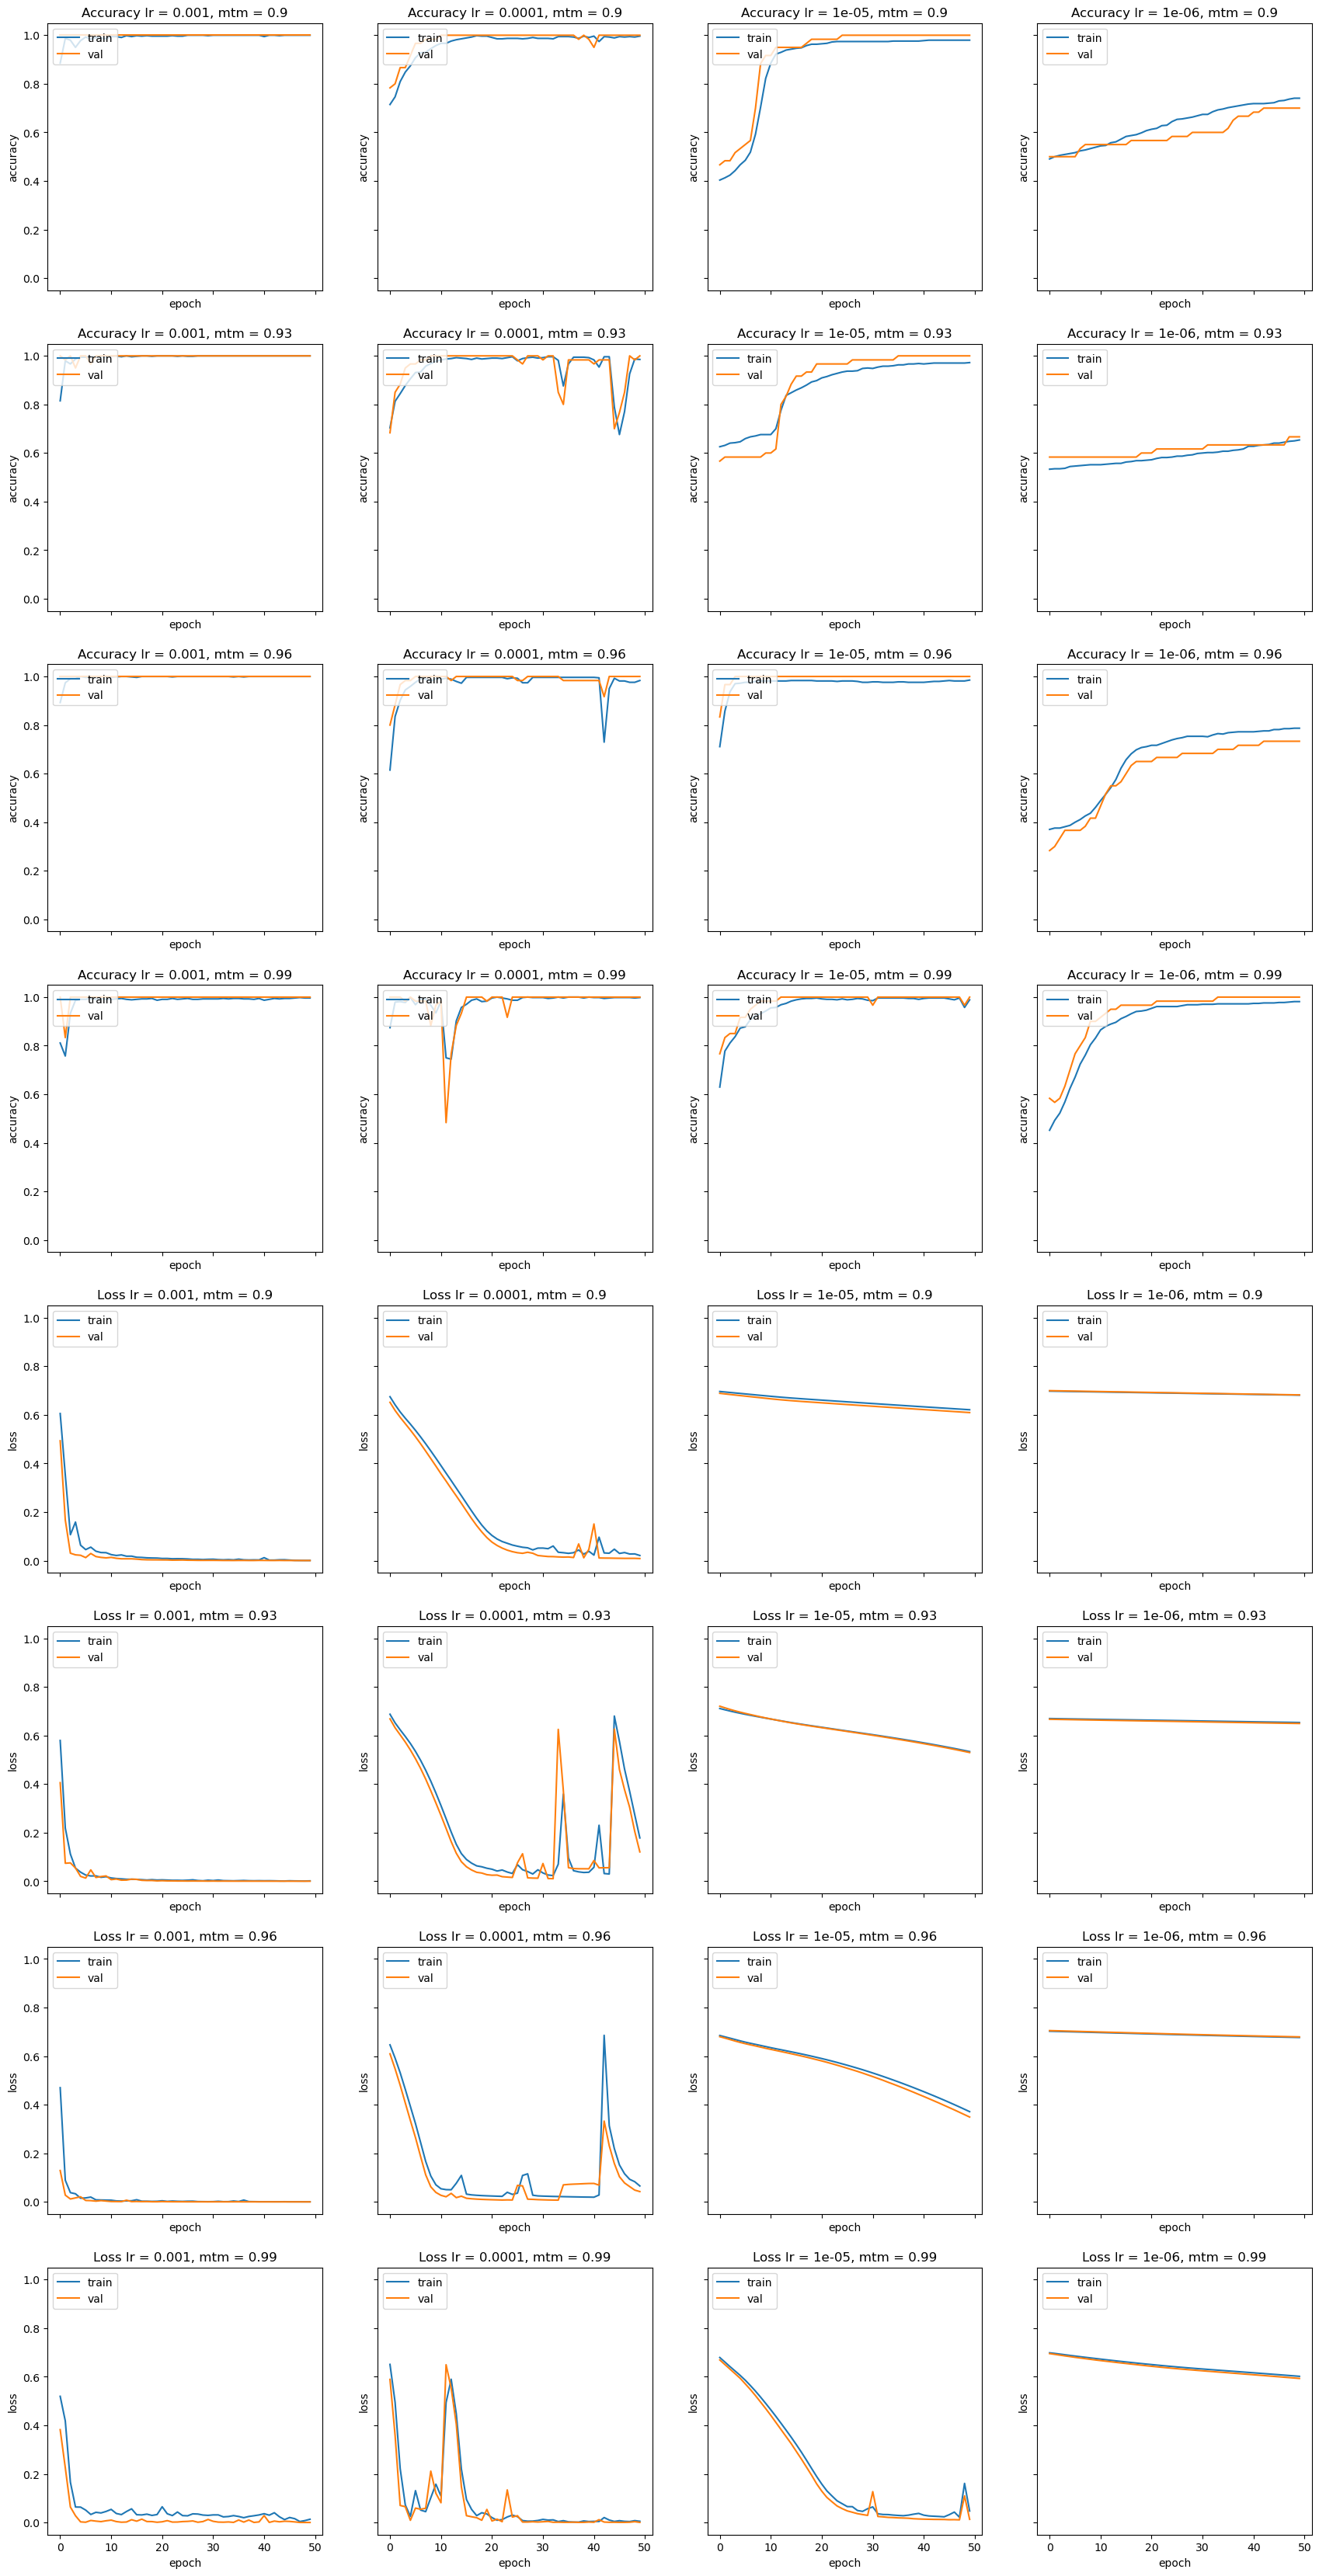

### 8) Testing the chosen models and picking a final one

Testing:
- SGD(lr = 0.001, momentum = 0.96) epochs = 20, batch_size = 4
- SGD(lr = 0.001, momentum = 0.93) epochs = 20, batch_size = 4
- Adam(lr = 0.001, beta_1 = 0.96) epochs = 15, batch_size = 4
- Adam(lr = 1e-05, beta_1 = 0.96) epochs = 30, batch_size = 4

In [108]:
sgd1 = optimizers.SGD(
            learning_rate = 0.001,
            momentum = 0.96)
                   
model1 = build_model(15, 8, sgd1) 
history1 = train_model(model1, epochs=20, batch=4)

2023-03-23 18:15:22.457839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-23 18:15:22.460125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-23 18:15:22.461687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2023-03-23 18:15:22.675387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-23 18:15:22.677494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-23 18:15:22.679006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

134/135 [============================>.] - ETA: 0s - loss: 0.6868 - accuracy: 0.6325

2023-03-23 18:15:27.990582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-23 18:15:27.992429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-23 18:15:27.993831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

135/135 [==============================] - 6s 28ms/step - loss: 0.6868 - accuracy: 0.6315 - val_loss: 0.6816 - val_accuracy: 0.7000
Epoch 2/20
135/135 [==============================] - 3s 22ms/step - loss: 0.6246 - accuracy: 0.8185 - val_loss: 0.5835 - val_accuracy: 0.7000
Epoch 3/20
135/135 [==============================] - 3s 22ms/step - loss: 0.4122 - accuracy: 0.8685 - val_loss: 0.2684 - val_accuracy: 1.0000
Epoch 4/20
135/135 [==============================] - 3s 22ms/step - loss: 0.4793 - accuracy: 0.8241 - val_loss: 0.5957 - val_accuracy: 0.7000
Epoch 5/20
135/135 [==============================] - 3s 22ms/step - loss: 0.5556 - accuracy: 0.6685 - val_loss: 0.4542 - val_accuracy: 0.7000
Epoch 6/20
135/135 [==============================] - 3s 21ms/step - loss: 0.3949 - accuracy: 0.8778 - val_loss: 0.2723 - val_accuracy: 0.9500
Epoch 7/20
135/135 [==============================] - 3s 21ms/step - loss: 0.2241 - accuracy: 0.9704 - val_loss: 0.1317 - val_accuracy: 1.0000
Epoch 8/20

In [109]:
sgd2 = optimizers.SGD(
            learning_rate = 0.001,
            momentum = 0.99)

model2 = build_model(15, 8, sgd2) 
history2 = train_model(model2, epochs=20, batch=4)

2023-03-23 18:16:23.877945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-23 18:16:23.880259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-23 18:16:23.881853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2023-03-23 18:16:24.335191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-23 18:16:24.337092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-23 18:16:24.338634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

134/135 [============================>.] - ETA: 0s - loss: 0.6064 - accuracy: 0.7276

2023-03-23 18:16:29.398322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-23 18:16:29.400496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-23 18:16:29.401874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

135/135 [==============================] - 6s 28ms/step - loss: 0.6046 - accuracy: 0.7296 - val_loss: 0.3503 - val_accuracy: 0.9833
Epoch 2/20
135/135 [==============================] - 3s 22ms/step - loss: 0.4085 - accuracy: 0.8870 - val_loss: 0.7493 - val_accuracy: 0.7000
Epoch 3/20
135/135 [==============================] - 3s 21ms/step - loss: 0.6021 - accuracy: 0.5981 - val_loss: 0.4642 - val_accuracy: 0.8333
Epoch 4/20
135/135 [==============================] - 3s 22ms/step - loss: 0.3852 - accuracy: 0.8593 - val_loss: 0.1816 - val_accuracy: 0.9833
Epoch 5/20
135/135 [==============================] - 3s 21ms/step - loss: 0.1205 - accuracy: 0.9889 - val_loss: 0.0341 - val_accuracy: 1.0000
Epoch 6/20
135/135 [==============================] - 3s 21ms/step - loss: 0.0347 - accuracy: 0.9963 - val_loss: 0.0753 - val_accuracy: 0.9833
Epoch 7/20
135/135 [==============================] - 3s 21ms/step - loss: 0.0243 - accuracy: 0.9963 - val_loss: 0.0795 - val_accuracy: 0.9833
Epoch 8/20

In [110]:
adam1 = optimizers.Adam(
                learning_rate = 0.001,
                beta_1 = 0.96)
                   
model3 = build_model(15, 8, adam1) 
history3 = train_model(model3, epochs=15, batch=4)

2023-03-23 18:17:25.785234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-23 18:17:25.787694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-23 18:17:25.789240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/15


2023-03-23 18:17:26.008951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-23 18:17:26.011305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-23 18:17:26.012850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

135/135 [==============================] - ETA: 0s - loss: 0.4685 - accuracy: 0.9185

2023-03-23 18:17:31.595607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-23 18:17:31.597767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-23 18:17:31.599513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

135/135 [==============================] - 6s 28ms/step - loss: 0.4685 - accuracy: 0.9185 - val_loss: 0.1920 - val_accuracy: 1.0000
Epoch 2/15
135/135 [==============================] - 3s 22ms/step - loss: 0.1414 - accuracy: 0.9889 - val_loss: 0.1443 - val_accuracy: 0.9833
Epoch 3/15
135/135 [==============================] - 3s 22ms/step - loss: 0.0744 - accuracy: 0.9963 - val_loss: 0.0515 - val_accuracy: 1.0000
Epoch 4/15
135/135 [==============================] - 3s 22ms/step - loss: 0.0895 - accuracy: 0.9852 - val_loss: 0.0344 - val_accuracy: 1.0000
Epoch 5/15
135/135 [==============================] - 3s 21ms/step - loss: 0.0495 - accuracy: 0.9907 - val_loss: 0.0271 - val_accuracy: 1.0000
Epoch 6/15
135/135 [==============================] - 3s 21ms/step - loss: 0.0312 - accuracy: 0.9963 - val_loss: 0.0200 - val_accuracy: 1.0000
Epoch 7/15
135/135 [==============================] - 3s 22ms/step - loss: 0.0240 - accuracy: 0.9981 - val_loss: 0.0152 - val_accuracy: 1.0000
Epoch 8/15

In [111]:
adam2 = optimizers.Adam(
                learning_rate = 1e-05,
                beta_1 = 0.99)
                   
model4 = build_model(15, 8, adam2) 
history4 = train_model(model4, epochs=70, batch=4)

2023-03-23 18:18:13.395929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-23 18:18:13.398247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-23 18:18:13.399636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/70


2023-03-23 18:18:13.604978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-23 18:18:13.606956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-23 18:18:13.608547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

134/135 [============================>.] - ETA: 0s - loss: 0.6744 - accuracy: 0.5616

2023-03-23 18:18:19.260156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-23 18:18:19.262048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-23 18:18:19.263339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

135/135 [==============================] - 6s 28ms/step - loss: 0.6744 - accuracy: 0.5593 - val_loss: 0.6624 - val_accuracy: 0.6500
Epoch 2/70
135/135 [==============================] - 3s 24ms/step - loss: 0.6710 - accuracy: 0.5704 - val_loss: 0.6592 - val_accuracy: 0.6500
Epoch 3/70
135/135 [==============================] - 3s 23ms/step - loss: 0.6674 - accuracy: 0.5889 - val_loss: 0.6560 - val_accuracy: 0.6833
Epoch 4/70
135/135 [==============================] - 3s 24ms/step - loss: 0.6639 - accuracy: 0.6093 - val_loss: 0.6527 - val_accuracy: 0.7000
Epoch 5/70
135/135 [==============================] - 3s 24ms/step - loss: 0.6603 - accuracy: 0.6389 - val_loss: 0.6493 - val_accuracy: 0.7333
Epoch 6/70
135/135 [==============================] - 3s 22ms/step - loss: 0.6567 - accuracy: 0.6796 - val_loss: 0.6459 - val_accuracy: 0.7333
Epoch 7/70
135/135 [==============================] - 3s 22ms/step - loss: 0.6529 - accuracy: 0.7037 - val_loss: 0.6423 - val_accuracy: 0.7667
Epoch 8/70

KeyboardInterrupt: 

In [112]:
def plot_model_acc_loss(history, param1_label, param1, param2_label, param2):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21,10), sharex=True, sharey=True)
    fig.suptitle('SGD: ' + param1_label + ' = ' + str(param1) + ', ' + param2_label + ' = ' + str(param2), size=18)

    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    axes[0].set_ylabel('accuracy')
    axes[0].set_xlabel('epoch')
    axes[0].legend(['train', 'val'], loc='upper left')

    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_ylabel('loss')
    axes[1].set_xlabel('epoch')
    axes[1].legend(['train', 'val'], loc='upper left')

    plt.show()

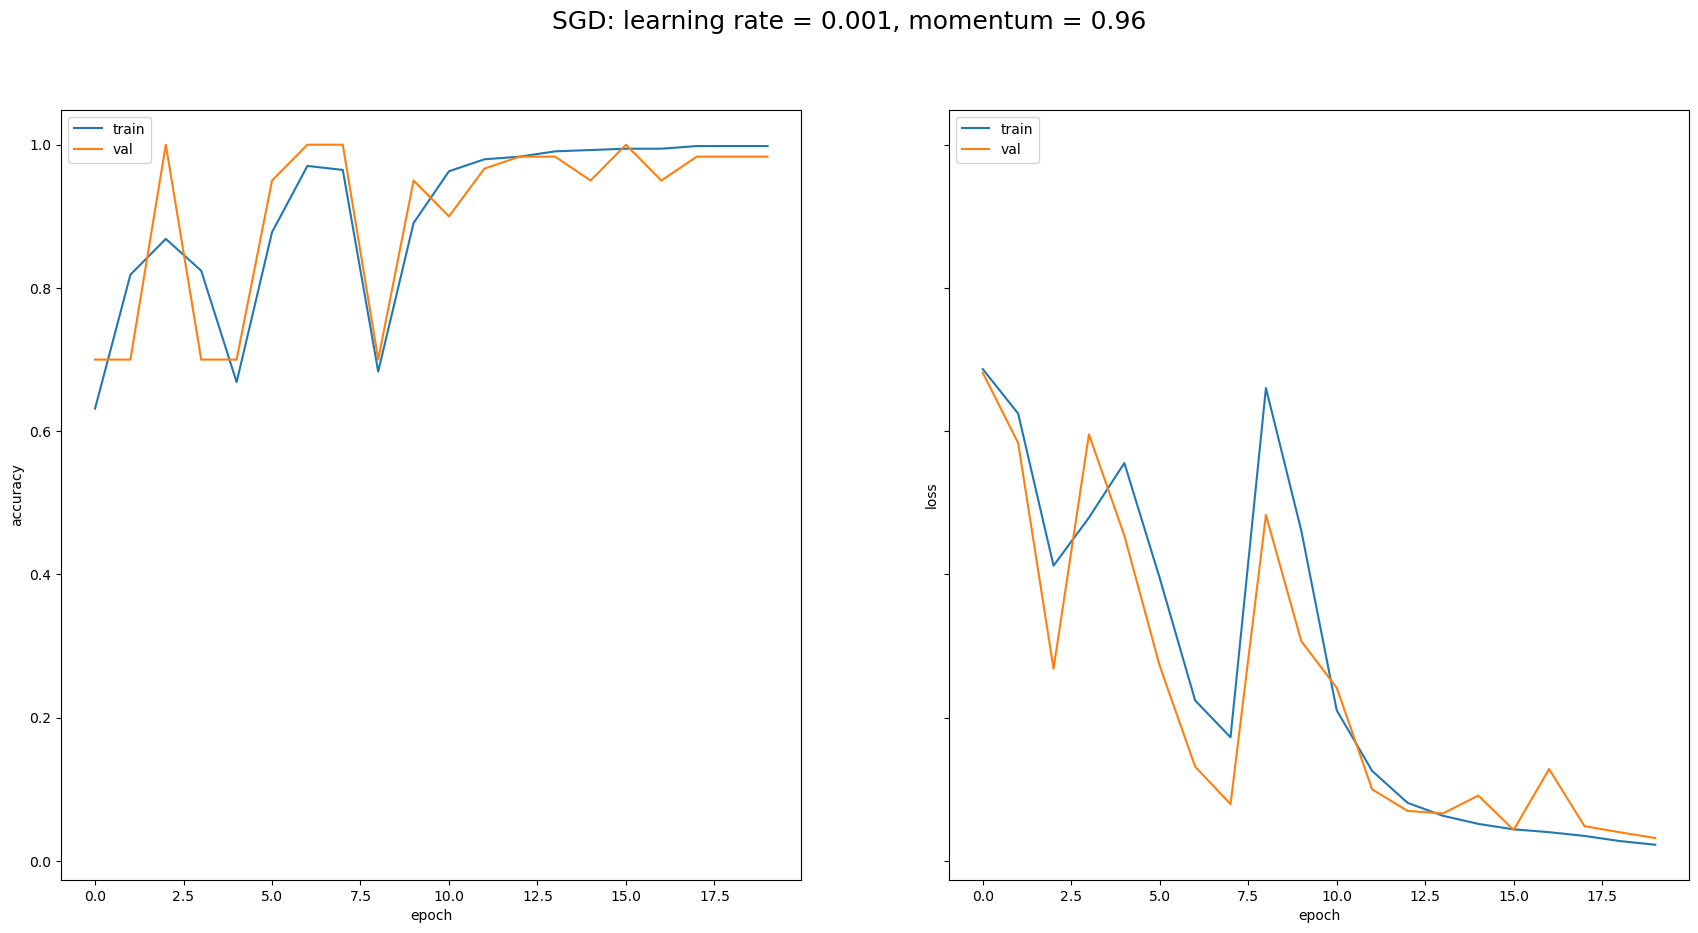

In [113]:
plot_model_acc_loss(history1, 'learning rate', 0.001, 'momentum', 0.96)

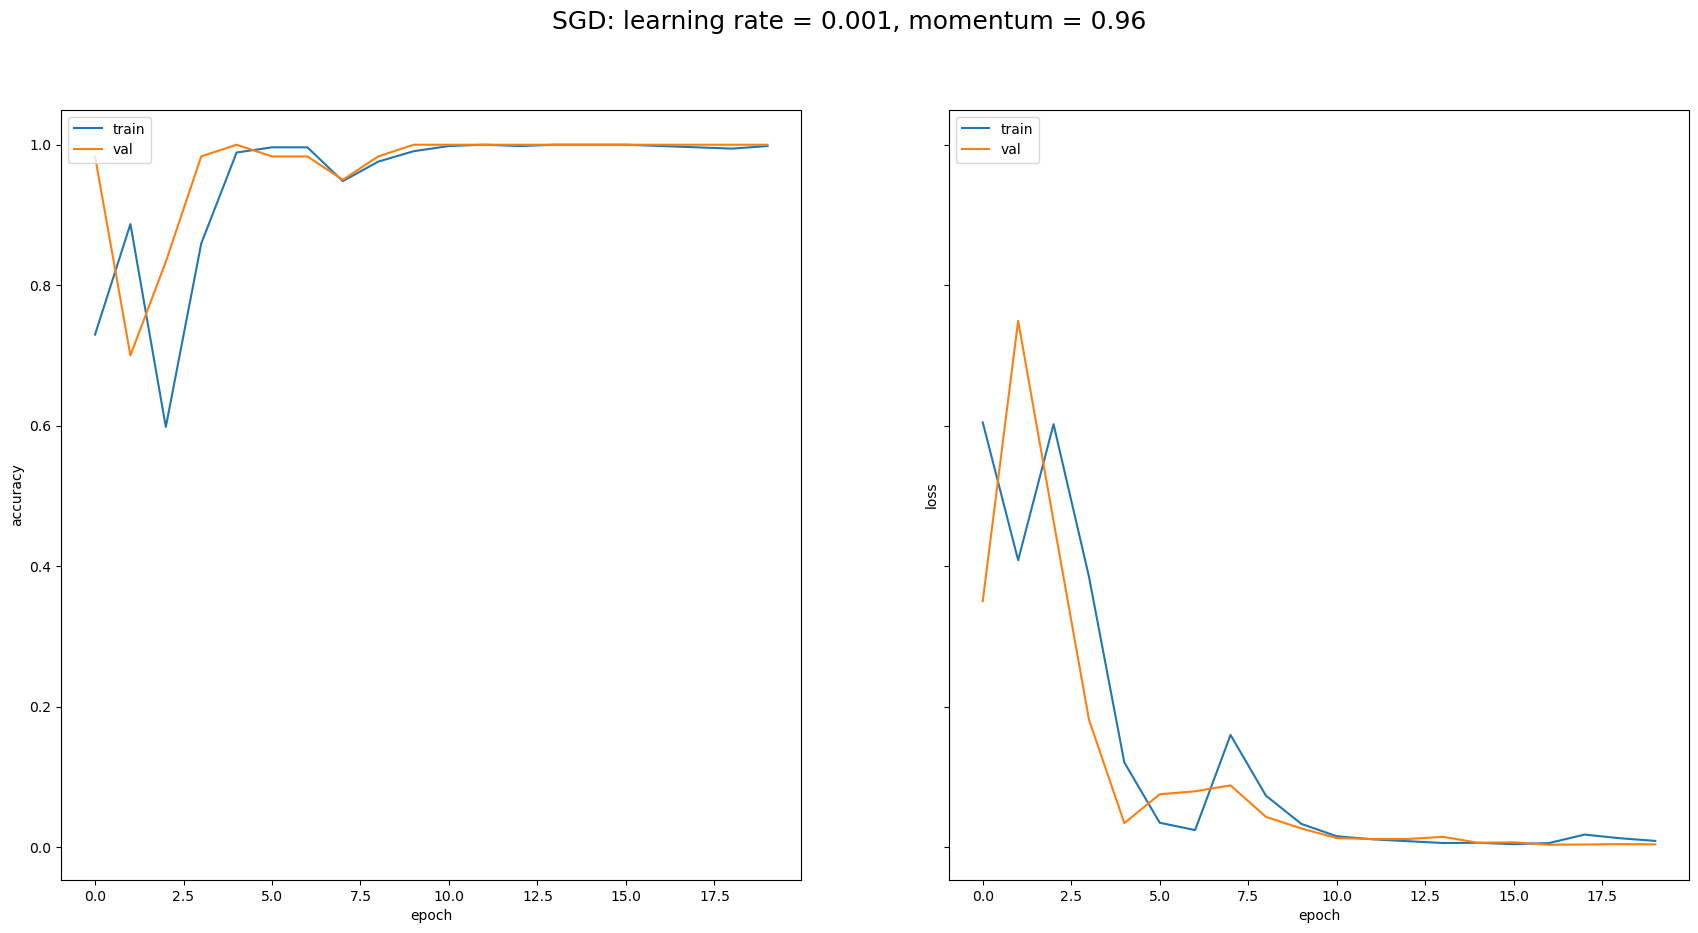

In [114]:
plot_model_acc_loss(history2, 'learning rate', 0.001, 'momentum', 0.96)

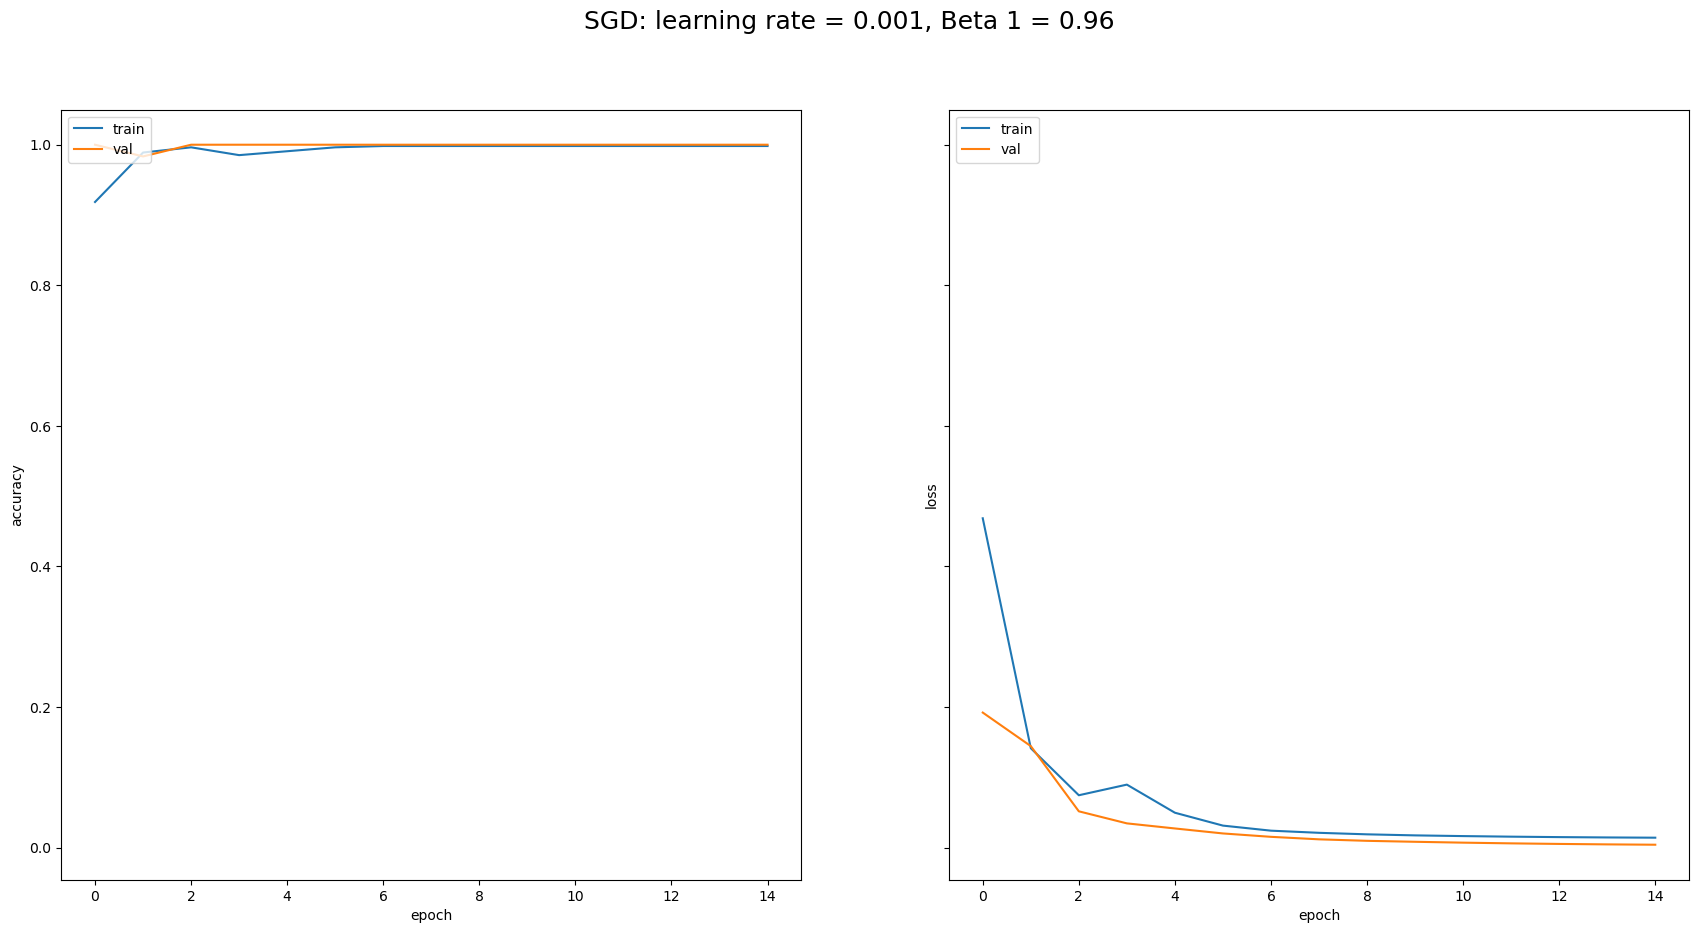

In [115]:
plot_model_acc_loss(history3, 'learning rate', 0.001, 'Beta 1', 0.96)

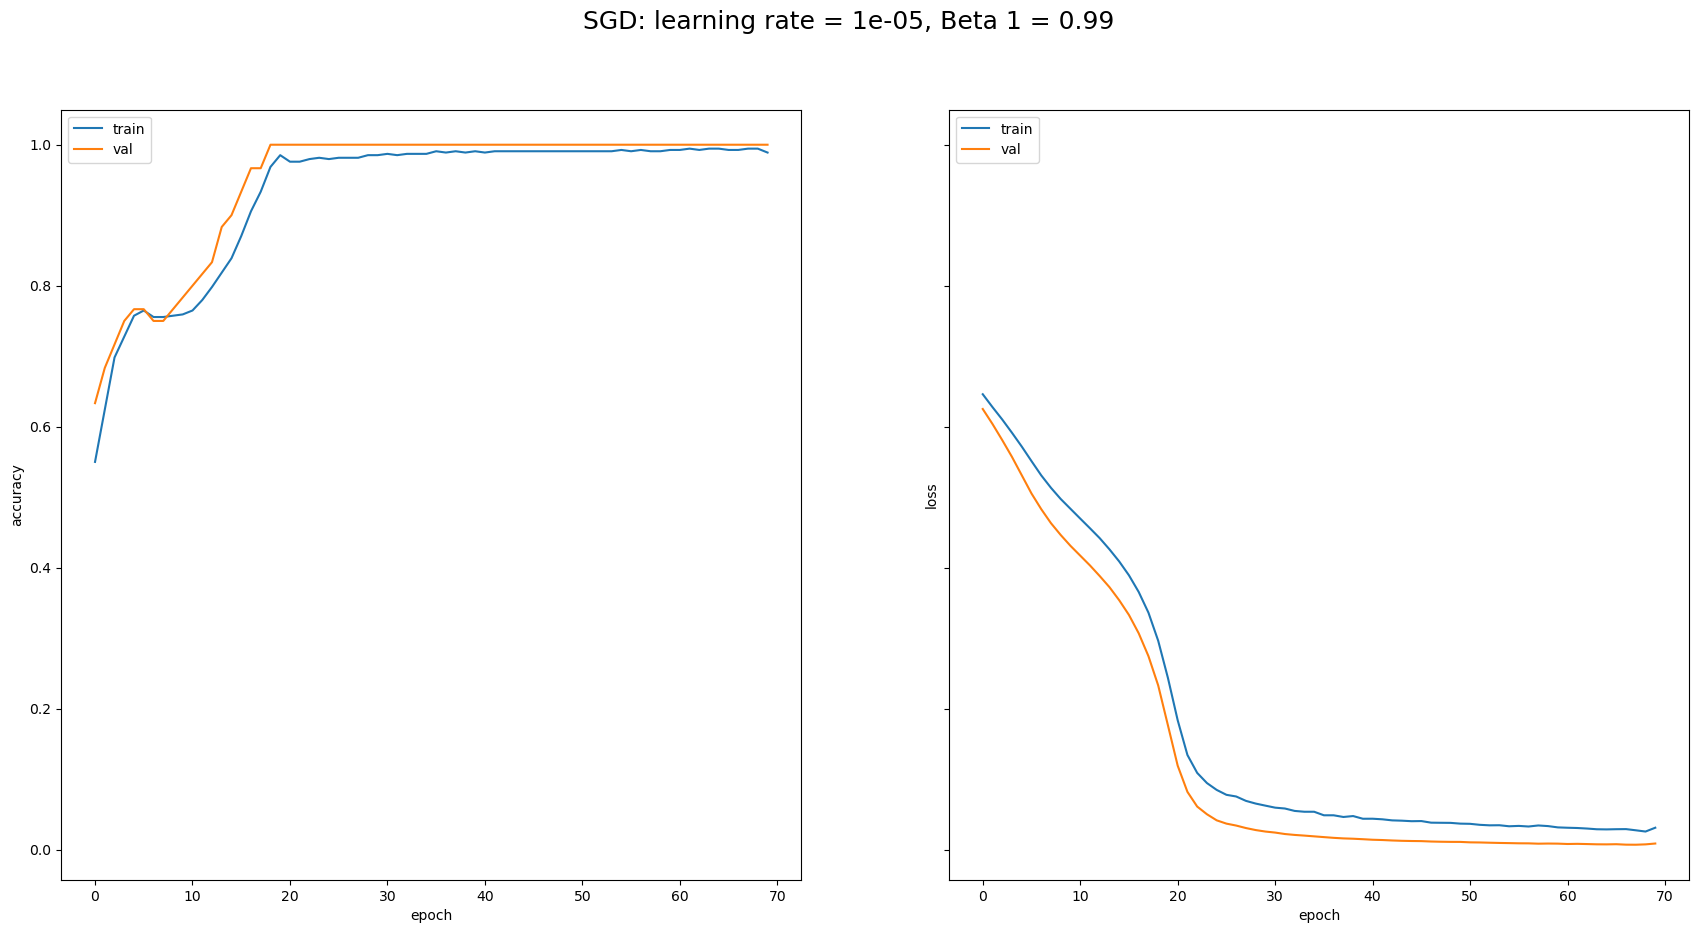

In [116]:
plot_model_acc_loss(history4, 'learning rate', 1e-05, 'Beta 1', 0.99)

### 9) Completing the submission

In [ ]:
sgd_final = optimizers.SGD(
            learning_rate = 0.001,
            momentum = 0.99)

model_final = build_model(15, 8, adam1) 
history_final = train_model(model_final, epochs=12, batch=2, val_split=0)

2023-03-23 18:20:25.223983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-23 18:20:25.226116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-23 18:20:25.227474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/12


2023-03-23 18:20:25.433469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-23 18:20:25.435527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-23 18:20:25.436913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

300/300 [==============================] - 8s 20ms/step - loss: 0.1868 - accuracy: 0.9500
Epoch 2/12
300/300 [==============================] - 6s 21ms/step - loss: 0.0429 - accuracy: 0.9933
Epoch 3/12
300/300 [==============================] - 6s 21ms/step - loss: 0.0500 - accuracy: 0.9867
Epoch 4/12
300/300 [==============================] - 7s 22ms/step - loss: 0.2905 - accuracy: 0.8500
Epoch 5/12
300/300 [==============================] - 6s 21ms/step - loss: 0.1135 - accuracy: 0.9533
Epoch 6/12
300/300 [==============================] - 6s 21ms/step - loss: 0.0524 - accuracy: 0.9983
Epoch 7/12
300/300 [==============================] - 6s 21ms/step - loss: 0.0346 - accuracy: 0.9967
Epoch 8/12
300/300 [==============================] - 6s 21ms/step - loss: 0.0287 - accuracy: 0.9933
Epoch 9/12
300/300 [==============================] - 6s 21ms/step - loss: 0.0238 - accuracy: 0.9933
Epoch 10/12
300/300 [==============================] - 6s 21ms/step - loss: 0.0225 - accuracy: 0.9967


In [98]:
target = model_final.predict(X_test_norm) # REMEMBER TO NORMAlISE TEST DATA

8/8 [==============================] - 0s 5ms/step


2023-03-23 18:12:45.162154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-23 18:12:45.164355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-23 18:12:45.165794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [99]:
target[target > 0.5] = True
target[target <= 0.5] = False
target_text = le.inverse_transform(target.astype("int"))

In [100]:
test_file["target"] = target_text

In [101]:
test_file.to_csv('submission_file_EY_Level1_2.csv', index=False)

In [102]:
t = pd.read_csv("submission_file_EY_Level1_2.csv")["target"] == pd.read_csv("submission_file_EY_Level1.csv")["target"]

In [103]:
t.sum()

241